# Wikipedia Pageviews Data
This notebook will create and analyze a dataset with accompanying graphs, detailing monthly webpage traffic to different Wikipedia articles.

I first create a Wikipedia Pageviews API call, which is a set of parameters and functions that are adapted from code developed by Dr. David W. McDonald, under a Creative Commons CC-BY license.

In [266]:
# These are standard python modules
import json, time, urllib.parse, pandas as pd, matplotlib.pyplot as plt
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

In [143]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': 'mrqs97@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023100100"    # this is likely the wrong end date
}


In [144]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")
    
    # access type will be an input to the call
    if access_type:
        request_template['access'] =  access_type
    if not request_template['access']:
        raise Exception("Must supply an access type to make a pageviews request.")
    

    # Titles are supposed to have spaces and slashes replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_').replace('/','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    
    # Cover the alternative case for mobile access types
    if 'mobile' in access_type:
        if access_type == 'mobile-app':
            request_template['access'] = 'mobile-web'
        else:
            request_template['access'] = 'mobile-app'
        request_url = endpoint_url+endpoint_params.format(**request_template)
        try:
            if API_THROTTLE_WAIT > 0.0:
                time.sleep(API_THROTTLE_WAIT)
            response = requests.get(request_url, headers=headers)
            json_response2 = response.json()
        except Exception as e:
            print(e)
            json_response2 = None
        for i in range(len(json_response['items'])):
            json_response['items'][i]['views'] = json_response['items'][i]['views'] + json_response2['items'][i]['views']
    
    # Remove 'access' field from JSON object
    json_response['items'] = [{key : val for key, val in item.items() if key != 'access'} for item in json_response['items']]

    return json_response


For this API call, we will be using a subset of Wikipedia article pages. This subset is loaded from the specified CSV file, and an example is shown below:

In [146]:
# Load the DataFrame from the CSV file
movies_df = pd.read_csv('thank_the_academy.AUG.2023.csv')
movies_sorted = movies_df['name'].sort_values()

movies_df

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Every...
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the...
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_...
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_W...
...,...,...
1354,The Yankee Doodle Mouse,https://en.wikipedia.org/wiki/The_Yankee_Doodl...
1355,The Yearling (1946 film),https://en.wikipedia.org/wiki/The_Yearling_(19...
1356,"Yesterday, Today and Tomorrow","https://en.wikipedia.org/wiki/Yesterday,_Today..."
1357,You Can't Take It with You (film),https://en.wikipedia.org/wiki/You_Can't_Take_I...


After loading the movies CSV file, we will make repeated API calls to the Wikipedia Pageviews API, using each title that we iterate through from the `movies_sorted` DataFrame. Then we save the resulting dictionary into a JSON file. This is performed three times:
1. We first get all mobile pageviews
2. Then we get all desktop pageviews
3. Finally we get all combined pageviews

**Note:** Each set of API calls will take several minutes to complete, since there are around 1300 API calls per JSON file

In [427]:
# To get all of the mobile data, we pass in the API call for articles with the "mobile-app" access type.
# The API call function has been modified so that we will get both mobile access types if we put either
# "mobile-app" or "mobile-web"
monthly_mobile = dict()
for movie in movies_sorted:
    monthly_mobile[movie] = request_pageviews_per_article(movie, 'mobile-app')['items']

# The resulting dictionary is then saved as a JSON file
with open('academy_monthly_mobile_201507-202310.json', 'w') as f:
    json.dump(monthly_mobile, f)

In [139]:
# We iterate through the DataFrame object once again, but this time we are interested in "desktop" pageviews
monthly_desktop = dict()
for movie in movies_sorted:
    monthly_desktop[movie] = request_pageviews_per_article(movie, 'desktop')['items']

# The resulting dictionary is saved as a JSON file
with open('academy_monthly_desktop_201507-202310.json', 'w') as f:
    json.dump(monthly_desktop, f)

12 Years a Slave (film)
1917 (2019 film)
20 Feet from Stardom
20,000 Leagues Under the Sea (1954 film)
2001: A Space Odyssey (film)
49th Parallel (film)
7 Faces of Dr. Lao
7th Heaven (1927 film)
8 Mile (film)
8½
A Beautiful Mind (film)
A Boy and His Dog (1946 film)
A Chance to Live
A Christmas Carol (1971 film)
A Close Shave
A Damsel in Distress (1937 film)
A Double Life (1947 film)
A Fantastic Woman
A Farewell to Arms (1932 film)
A Fish Called Wanda
A Free Soul
A Funny Thing Happened on the Way to the Forum (film)
A Girl in the River: The Price of Forgiveness
A Greek Tragedy
A Herb Alpert and the Tijuana Brass Double Feature
A Hole in the Head
A Letter to Three Wives
A Little Night Music (film)
A Little Romance
A Man and a Woman
A Man for All Seasons (1966 film)
A Midsummer Night's Dream (1935 film)
A Note of Triumph: The Golden Age of Norman Corwin
A Passage to India (film)
A Patch of Blue
A Place in the Sun (1951 film)
A Place to Stand (film)
A River Runs Through It (film)
A Room wi

Genocide (1981 film)
Gentleman's Agreement
Gerald McBoing-Boing
Geri's Game
Get Out
Get Out Your Handkerchiefs
Ghost (1990 film)
Giant (1956 film)
Gigi (1958 film)
Girl, Interrupted (film)
Giuseppina
Give Me Liberty (1936 film)
Gladiator (2000 film)
Glass (1958 film)
Glory (1989 film)
God of Love (film)
Gods and Monsters (film)
Going My Way
Gold Diggers of 1935
Goldfinger (film)
Gone with the Wind (film)
Good Will Hunting
Goodbye, Miss Turlock
Goodbye, Mr. Chips (1939 film)
Goodfellas
Gosford Park
Grand Canyon (1958 film)
Grand Hotel (1932 film)
Grand Prix (1966 film)
Grandad of Races
Gravity (2013 film)
Gravity Is My Enemy
Great (1975 film)
Great Expectations (1946 film)
Green Book (film)
Green Dolphin Street (film)
Guess Who's Coming to Dinner
Guillermo del Toro's Pinocchio
Hacksaw Ridge
Hair Love
Hamlet (1948 film)
Hannah and Her Sisters
Happy Feet
Harlan County, USA
Harry and Tonto
Harry and the Hendersons
Harvey (1950 film)
Harvie Krumpet
He Makes Me Feel Like Dancin'
Hearts and M

Rocketman (film)
Rocky
Roma (2018 film)
Roman Holiday
Romeo and Juliet (1968 film)
Room (2015 film)
Room at the Top (1959 film)
Rosemary's Baby (film)
Round Midnight (film)
Ryan (film)
Ryan's Daughter
Sabrina (1954 film)
Samson and Delilah (1949 film)
Samurai I: Musashi Miyamoto
San Francisco (1936 film)
Save the Tiger
Saving Face (2012 film)
Saving Private Ryan
Sayonara
Scared Straight!
Scent of a Woman (1992 film)
Schindler's List
Schwarzfahrer
Seal Island (film)
Searching for Sugar Man
Seawards the Great Ships
Seeds of Destiny
Selma (film)
Sense and Sensibility (film)
Sentinels of Silence
Separate Tables (film)
Serengeti Shall Not Die
Sergeant York (film)
Session Man (film)
Seven Brides for Seven Brothers
Seven Days to Noon
Shaft (1971 film)
Shakespeare in Love
Shampoo (film)
Shane (film)
Shanghai Express (film)
She Wore a Yellow Ribbon
Shine (film)
Ship of Fools (film)
Shoeshine (film)
Shrek
Sideways
Silver Linings Playbook
Since You Went Away
Sing (2016 Hungarian film)
Six Shooter

The Pianist (2002 film)
The Piano
The Picture of Dorian Gray (1945 film)
The Pink Phink
The Poseidon Adventure (1972 film)
The Power of the Dog (film)
The Pride of the Yankees
The Prime of Miss Jean Brodie (film)
The Prince of Egypt
The Private Life of Henry VIII
The Private Life of the Gannets
The Producers (1967 film)
The Public Pays
The Queen (2006 film)
The Queen of Basketball
The Quiet Man
The Rains Came
The Razor's Edge (1946 film)
The Reader (2008 film)
The Red Balloon
The Red Shoes (1948 film)
The Red Violin
The Redwoods
The Resurrection of Broncho Billy
The Revenant (2015 film)
The Right Stuff (film)
The River (1984 film)
The Robe (film)
The Rose Tattoo (film)
The Salesman (2016 film)
The Sand Castle (film)
The Sandpiper
The Scoundrel (1935 film)
The Sea Around Us (film)
The Sea Inside
The Search
The Secret Land
The Secret in Their Eyes
The Seventh Veil
The Shape of Water
The Shop on Main Street
The Shore (2011 film)
The Silence of the Lambs (film)
The Silent Child
The Silent 

In [140]:
# We perform the set of API calls one more time to get the cumulative pageviews.
# Note that the API call accepts "all-access" as a parameter, which gets both mobile and desktop views, according
# to the Wikipedia Pageviews API
monthly_cumul = dict()
for movie in movies_sorted:
    monthly_cumul[movie] = request_pageviews_per_article(movie, 'all-access')['items']

# The resulting dictionary is saved as a JSON file
with open('academy_monthly_cumulative_201507-202310.json', 'w') as f:
    json.dump(monthly_cumul, f)

12 Years a Slave (film)
1917 (2019 film)
20 Feet from Stardom
20,000 Leagues Under the Sea (1954 film)
2001: A Space Odyssey (film)
49th Parallel (film)
7 Faces of Dr. Lao
7th Heaven (1927 film)
8 Mile (film)
8½
A Beautiful Mind (film)
A Boy and His Dog (1946 film)
A Chance to Live
A Christmas Carol (1971 film)
A Close Shave
A Damsel in Distress (1937 film)
A Double Life (1947 film)
A Fantastic Woman
A Farewell to Arms (1932 film)
A Fish Called Wanda
A Free Soul
A Funny Thing Happened on the Way to the Forum (film)
A Girl in the River: The Price of Forgiveness
A Greek Tragedy
A Herb Alpert and the Tijuana Brass Double Feature
A Hole in the Head
A Letter to Three Wives
A Little Night Music (film)
A Little Romance
A Man and a Woman
A Man for All Seasons (1966 film)
A Midsummer Night's Dream (1935 film)
A Note of Triumph: The Golden Age of Norman Corwin
A Passage to India (film)
A Patch of Blue
A Place in the Sun (1951 film)
A Place to Stand (film)
A River Runs Through It (film)
A Room wi

Genocide (1981 film)
Gentleman's Agreement
Gerald McBoing-Boing
Geri's Game
Get Out
Get Out Your Handkerchiefs
Ghost (1990 film)
Giant (1956 film)
Gigi (1958 film)
Girl, Interrupted (film)
Giuseppina
Give Me Liberty (1936 film)
Gladiator (2000 film)
Glass (1958 film)
Glory (1989 film)
God of Love (film)
Gods and Monsters (film)
Going My Way
Gold Diggers of 1935
Goldfinger (film)
Gone with the Wind (film)
Good Will Hunting
Goodbye, Miss Turlock
Goodbye, Mr. Chips (1939 film)
Goodfellas
Gosford Park
Grand Canyon (1958 film)
Grand Hotel (1932 film)
Grand Prix (1966 film)
Grandad of Races
Gravity (2013 film)
Gravity Is My Enemy
Great (1975 film)
Great Expectations (1946 film)
Green Book (film)
Green Dolphin Street (film)
Guess Who's Coming to Dinner
Guillermo del Toro's Pinocchio
Hacksaw Ridge
Hair Love
Hamlet (1948 film)
Hannah and Her Sisters
Happy Feet
Harlan County, USA
Harry and Tonto
Harry and the Hendersons
Harvey (1950 film)
Harvie Krumpet
He Makes Me Feel Like Dancin'
Hearts and M

Rocketman (film)
Rocky
Roma (2018 film)
Roman Holiday
Romeo and Juliet (1968 film)
Room (2015 film)
Room at the Top (1959 film)
Rosemary's Baby (film)
Round Midnight (film)
Ryan (film)
Ryan's Daughter
Sabrina (1954 film)
Samson and Delilah (1949 film)
Samurai I: Musashi Miyamoto
San Francisco (1936 film)
Save the Tiger
Saving Face (2012 film)
Saving Private Ryan
Sayonara
Scared Straight!
Scent of a Woman (1992 film)
Schindler's List
Schwarzfahrer
Seal Island (film)
Searching for Sugar Man
Seawards the Great Ships
Seeds of Destiny
Selma (film)
Sense and Sensibility (film)
Sentinels of Silence
Separate Tables (film)
Serengeti Shall Not Die
Sergeant York (film)
Session Man (film)
Seven Brides for Seven Brothers
Seven Days to Noon
Shaft (1971 film)
Shakespeare in Love
Shampoo (film)
Shane (film)
Shanghai Express (film)
She Wore a Yellow Ribbon
Shine (film)
Ship of Fools (film)
Shoeshine (film)
Shrek
Sideways
Silver Linings Playbook
Since You Went Away
Sing (2016 Hungarian film)
Six Shooter

The Pianist (2002 film)
The Piano
The Picture of Dorian Gray (1945 film)
The Pink Phink
The Poseidon Adventure (1972 film)
The Power of the Dog (film)
The Pride of the Yankees
The Prime of Miss Jean Brodie (film)
The Prince of Egypt
The Private Life of Henry VIII
The Private Life of the Gannets
The Producers (1967 film)
The Public Pays
The Queen (2006 film)
The Queen of Basketball
The Quiet Man
The Rains Came
The Razor's Edge (1946 film)
The Reader (2008 film)
The Red Balloon
The Red Shoes (1948 film)
The Red Violin
The Redwoods
The Resurrection of Broncho Billy
The Revenant (2015 film)
The Right Stuff (film)
The River (1984 film)
The Robe (film)
The Rose Tattoo (film)
The Salesman (2016 film)
The Sand Castle (film)
The Sandpiper
The Scoundrel (1935 film)
The Sea Around Us (film)
The Sea Inside
The Search
The Secret Land
The Secret in Their Eyes
The Seventh Veil
The Shape of Water
The Shop on Main Street
The Shore (2011 film)
The Silence of the Lambs (film)
The Silent Child
The Silent 

After saving each JSON file, we load them as DataFrame objects. Afterwards, we combine all of them into one DataFrame. A preview is shown after combining the data

In [428]:
# Open the JSON file for mobile pageviews as a dictionary, append each list from the dictionary values
# and convert into a DataFrame
f = open('academy_monthly_mobile_201507-202310.json')
combined = []
for sub_list in json.load(f).values():
    combined.extend(sub_list)
f.close()
df_mobile = pd.DataFrame.from_dict(combined)
df_mobile['access'] = 'mobile' # We are adding an additional column for access type so that we can combine the DataFrames 

# Repeat for the desktop pageviews data
f = open('academy_monthly_desktop_201507-202310.json')
combined = []
for sub_list in json.load(f).values():
    combined.extend(sub_list)
f.close()
df_desktop = pd.DataFrame.from_dict(combined)
df_desktop['access'] = 'desktop'

# Repeat for the cumulative pageviews data
f = open('academy_monthly_cumulative_201507-202310.json')
combined = []
for sub_list in json.load(f).values():
    combined.extend(sub_list)
f.close()
df_cumulative = pd.DataFrame.from_dict(combined)
df_cumulative['access'] = 'cumulative'

# Combine all DataFrames into one
df_all = pd.concat([df_mobile, df_desktop, df_cumulative], ignore_index=True)

df_all

,project,article,granularity,timestamp,agent,views,access
0,en.wikipedia,12_Years_a_Slave_(film),monthly,2015070100,user,75458,mobile
1,en.wikipedia,12_Years_a_Slave_(film),monthly,2015080100,user,64091,mobile
2,en.wikipedia,12_Years_a_Slave_(film),monthly,2015090100,user,53916,mobile
3,en.wikipedia,12_Years_a_Slave_(film),monthly,2015100100,user,61688,mobile
4,en.wikipedia,12_Years_a_Slave_(film),monthly,2015110100,user,61671,mobile
...,...,...,...,...,...,...,...
386872,en.wikipedia,Zorba_the_Greek_(film),monthly,2023050100,user,13025,cumulative
386873,en.wikipedia,Zorba_the_Greek_(film),monthly,2023060100,user,12631,cumulative
386874,en.wikipedia,Zorba_the_Greek_(film),monthly,2023070100,user,20739,cumulative
386875,en.wikipedia,Zorba_the_Greek_(film),monthly,2023080100,user,19522,cumulative


## Analysis
After creating the combined DataFrame, we will go on to use it to accomplish several tasks:
### Minimum Average and Maximum Average
For this analysis task, we are interested in finding the articles with the highest and lowest average monthly page requests for both mobile and desktop access. Then we will plot a time series chart to highlight the monthly pagecounts for all four categories.

In [430]:
# We group by "article" and "access" and then use the mean() function to get the average monthly views
# per article and access type
monthly_access = df_all.groupby(['article', 'access'], as_index=False).mean('views')

In [431]:
# Since we specifically want those with the highest and lowest monthly averages, we once filter the data to get only
# articles with the highest and lowest monthly averages for each access type
max_views = monthly_access.groupby('access', as_index=False).max('views')
max_views['type'] = 'max ' + max_views['access']
min_views = monthly_access.groupby('access', as_index=False).min('views')
min_views['type'] = 'min ' + min_views['access']
views = pd.concat([max_views, min_views], ignore_index=True)
views = views.loc[views['access'] != 'cumulative']

# We join the views table with the average monthly views to get recover information on the article titles. This is then
# joined with the master dataset `df_all` to get month-by-month viewcounts for each of these article titles and access types
timeseries = pd.merge(pd.merge(views, monthly_access, on=['access', 'views'], how='inner').drop('views', axis=1), df_all, on=['access', 'article'], how='inner')
timeseries['timestamp'] = pd.to_datetime(timeseries['timestamp'], format='%Y%m%d%H')

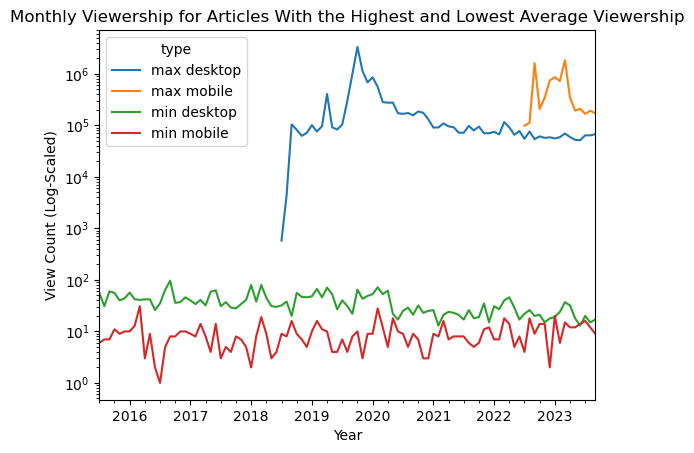

In [425]:
# We create a plot from the dataframe, and resize scales so that the data can be more easily viewed
timeseries.pivot(index='timestamp', columns='type', values='views').plot()

plt.semilogy() # Transform Y-Axis to a Logarithmic Scale
plt.title('Monthly Viewership for Articles With the Highest and Lowest Average Viewership')
plt.xlabel('Year')
plt.ylabel('View Count (Log-Scaled)')
plt.savefig('MinMaxAvgViewership.png', bbox_inches='tight') # Saves the figure to a PNG file with tight padding
plt.show()

### Top  10 Peak Page Views
In this analysis task we are interested in finding the top 10 articles with the largest peak pageviews, for each access type. That is, we want to find the top 10 articles that had the highest peak monthly page count for both desktop and mobile access.

We will first filter the data, then plot the resulting time series data

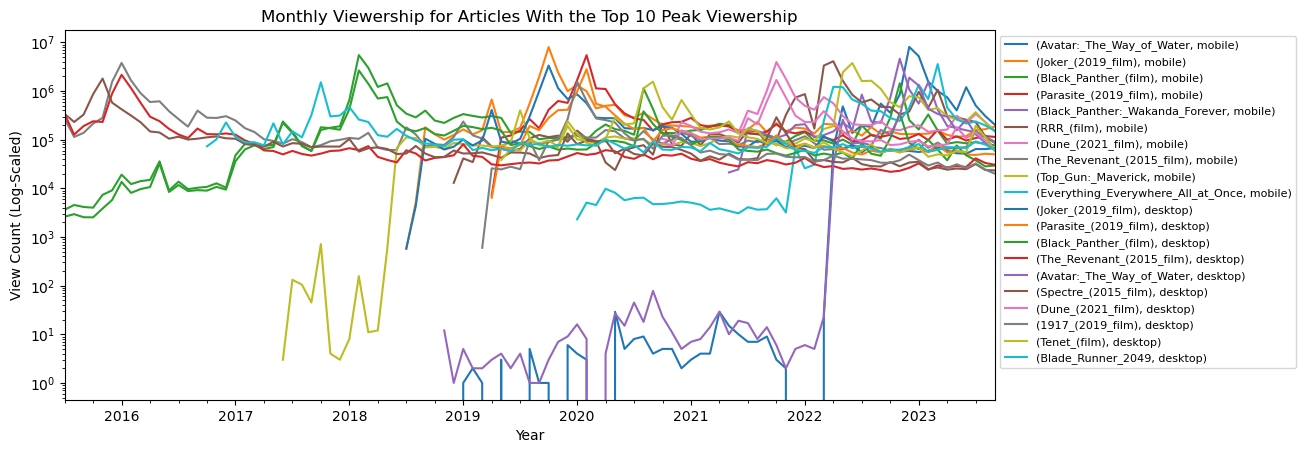

In [432]:
# We group by 'article' and 'access' and then use the max() function to get the peak page count for each article
# and access type
peak_access = df_all.groupby(['article', 'access'], as_index=False).max('views')
peak_access = peak_access.loc[peak_access['access'] != 'cumulative']

# We filter for articles with the highest peak page counts for each access type, then merge with the master table 'df_all'
# to recover the monthly page views for these articles and access types
peak_access = pd.merge(peak_access.sort_values(['access', 'views'], ascending=False).groupby('access').head(10).drop(columns='views'), df_all, on=['article', 'access'], how='inner')
peak_access['timestamp'] = pd.to_datetime(peak_access['timestamp'], format='%Y%m%d%H')

# We create a plot from the dataframe, and resize scales so that the data can be more easily viewed
peak_access.pivot(index='timestamp', columns=['article', 'access'], values='views').plot(figsize=(12,4.8))

plt.legend(prop={'size': 8}, bbox_to_anchor=(1,1)) # This will position the legend outside of the plot
plt.semilogy() # Transform Y-axis into a Logarithmic Scale for easier viewing
plt.title('Monthly Viewership for Articles With the Top 10 Peak Viewership')
plt.xlabel('Year')
plt.ylabel('View Count (Log-Scaled)')
plt.savefig('PeakViewership.png', dpi=500, bbox_inches='tight')
plt.show()

### Fewest Months of Data
In this analysis task we are interested in finding the top 10 articles that have the fewest months of data. These will be the most recent academy award winners.

We filter the data for those with the least months of data for both mobile and desktop access, then plot the resulting data as a time series chart.

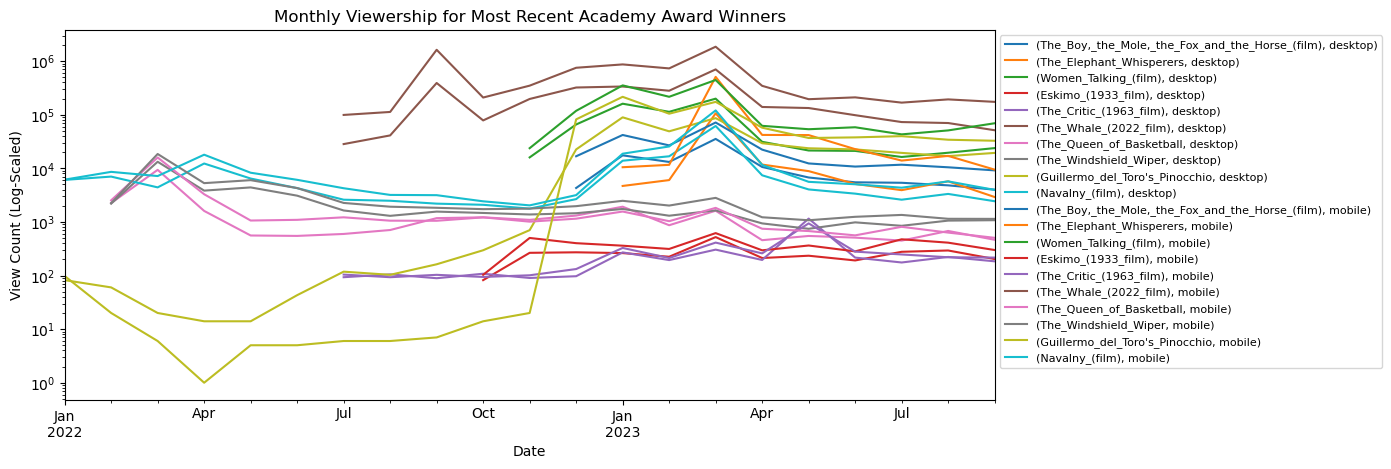

In [422]:
# First we derive counts for each article and access type, which corresponds to the number of available months
# of Pageview data
fewest_months = df_all.groupby(['article', 'access'], as_index=False).project.agg('count')

fewest_months = fewest_months.loc[fewest_months['access'] != 'cumulative'] # We are not interested in cumulative counts

# We sort and filter the data to get only the top 10 articles in terms of fewest pagecounts for both mobile and desktop access
# Then we merge with the master DataFrame 'df_all' to recover their corresponding monthly page counts
fewest_months = pd.merge(fewest_months.sort_values(['access', 'project']).groupby('access').head(10).drop(columns='project'), df_all, on=['article', 'access'], how='inner')
fewest_months['timestamp'] = pd.to_datetime(fewest_months['timestamp'], format='%Y%m%d%H')

# We create a plot from the dataframe, and resize scales so that the data can be more easily viewed
fewest_months.pivot(index='timestamp', columns=['article', 'access'], values='views').plot(figsize=(12, 4.8))

plt.legend(prop={'size': 8}, bbox_to_anchor=(1,1)) # We put the legend outside of the plot for easier viewing
plt.semilogy() # Logarithmic Transformation of the Y-axis allows us to see lines much more clearly
plt.title('Monthly Viewership for Most Recent Academy Award Winners')
plt.xlabel('Date')
plt.ylabel('View Count (Log-Scaled)')
plt.savefig('MostRecentWinners.png', dpi=500, bbox_inches='tight')
plt.show()

In [1]:
from platform import python_version

print(python_version())


3.9.16
